# Demostration of image reconstruction workflow

In [1]:
# Settings are global packages
import sys
import torch
sys.path.append("../")
# data settings
data_root_path = "../data/sd_5" 
batch_size = 2**15
num_epochs = 50
# model settings
resolution_finest = [512, 512]
resolution_coarsest = [32, 32]
num_levels = 5
feature_length = 6
mlp_hiddens = [64, 64]
device = torch.device("cuda")
lr = 0.001

### Prepare data

In [2]:
from torch.utils.data import DataLoader
from dgir.data import DenseGridImageDataset

dataset = DenseGridImageDataset(data_root_path)
train_size = int(len(dataset)*0.99)
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 91.68it/s]


### Show one example image from data

image_id: 2 , shape: torch.Size([3, 2048, 1280])


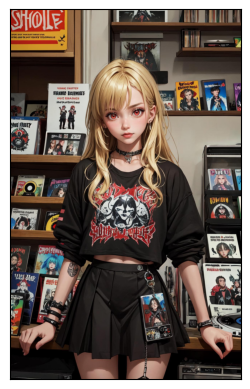

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

def show_imgs(imgs, epoch=None, psnr=None):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img[:3,:,:].detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        if epoch:
            axs[0, i].set_title("epoch: {}, psnr: {:.2f}".format(epoch, psnr))

image_id = np.random.randint(len(dataset.images))
print("image_id:", image_id, ", shape:", dataset.images[image_id]["shape"])
show_imgs(dataset.images[image_id]["data"])

### Prepare model

In [4]:
from dgir.model import DenseGridNet
import torch.nn as nn

model = DenseGridNet(resolution_finest, resolution_coarsest, num_levels, feature_length, mlp_hiddens)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

channel_loss = nn.MSELoss()

def rgb_loss(pred, target):
    return channel_loss(pred[:,0], target[:,0]) + channel_loss(pred[:,1], target[:,1]) + channel_loss(pred[:,2], target[:,2]) 
    

### Training

In [5]:
def train(model, dataloader):
    model.train()
    losses = []
    for d in dataloader:
        optimizer.zero_grad()
        d = d.to(device)
        x = d[:,:3]
        target = d[:,3:6]/255.
        o = model(x)
        loss = rgb_loss(o, target)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    return torch.tensor(losses)

def test(model, dataloader):
    model.eval()
    losses = []
    for d in dataloader:
        d = d.to(device)
        x = d[:,:3]
        target = d[:,3:6]/255.
        o = model(x)
        loss = rgb_loss(o, target)
        losses.append(loss.item())
    return torch.tensor(losses)

In [ ]:
from tqdm import tqdm
from dgir.util import reconstruct_image, compute_dataset_psnr, compute_psnr

show_interval = 5

pbar = tqdm(range(1,num_epochs+1))
tr_losses = []
ts_losses = []
psnr_scores = []
for epoch in pbar:
    train_losses = train(model, train_dataloader)
    test_losses = test(model, test_dataloader)
    tr_loss = torch.mean(train_losses).item()
    ts_loss = torch.mean(test_losses).item()

    img_shape = dataset.images[image_id]["shape"]
    recon_img = reconstruct_image(model, image_id, img_shape[2], img_shape[1])
    psnrs = compute_dataset_psnr(model, dataset)
    
    pbar.set_description("train: {:.5f}, test: {:.5f}, psnr: {:.2f}".format(tr_loss, ts_loss, np.mean(psnrs)))
    tr_losses.append(tr_loss)
    ts_losses.append(ts_loss)
    psnr_scores.append(np.mean(psnrs))
    
    if epoch % show_interval == 0:
        recon_img = reconstruct_image(model, image_id, img_shape[2], img_shape[1])
        psnr = compute_psnr(dataset.images[image_id]["data"], recon_img.cpu()).item()
        show_imgs(recon_img, epoch, psnr)
        

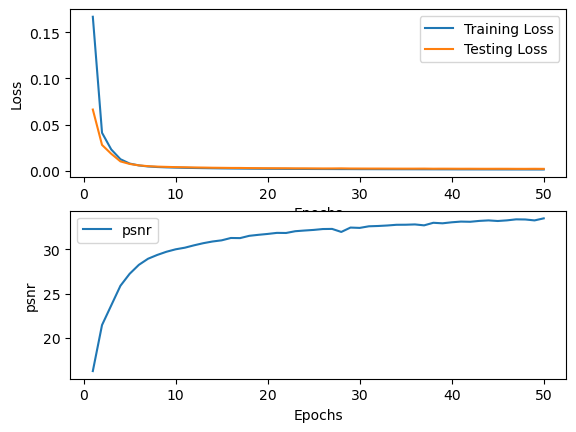

In [7]:
def plot_training_curves(epochs, tr_losses, ts_losses, psnr_scores):
    fig, axs = plt.subplots(nrows=2, squeeze=False)
    axs[0, 0].plot(epochs, tr_losses, label='Training Loss')
    axs[0, 0].plot(epochs, ts_losses, label='Testing Loss')
    axs[0, 0].legend(loc='best')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    
    axs[1, 0].plot(epochs, psnr_scores, label='psnr')
    axs[1, 0].legend(loc='best')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('psnr')

plot_training_curves(range(1, num_epochs+1), tr_losses, ts_losses, psnr_scores[:100])

### Visualize image reconstruction

In [8]:
def plot_recon_image(gt, recon_img):
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5), squeeze=False)
    gt = gt[:3,:,:].detach()
    gt = F.to_pil_image(gt)
    axs[0, 0].imshow(np.array(gt))
    axs[0, 0].set_title('GT')

    recon_img = recon_img[:3,:,:].detach()
    recon_img = F.to_pil_image(recon_img)
    axs[0, 1].imshow(np.array(recon_img))
    axs[0, 1].set_title('Reconstructed')
    
    for axis in fig.axes:
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

def plot_dataset_recon(model, dataset):
    for image_id in dataset.images.keys():
        data = dataset.images[image_id]["data"]
        shape = dataset.images[image_id]["shape"]
        rec_img = reconstruct_image(model, image_id, shape[2], shape[1])
        plot_recon_image(data, rec_img.cpu())
        

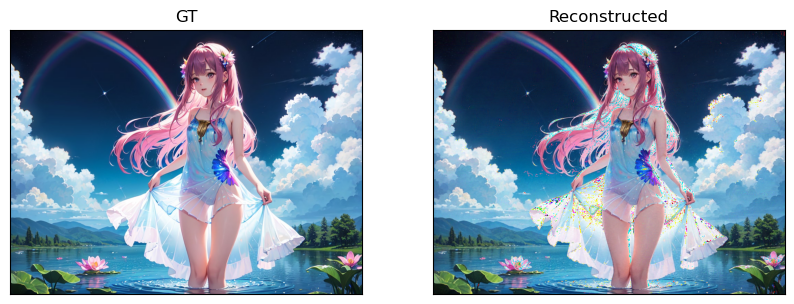

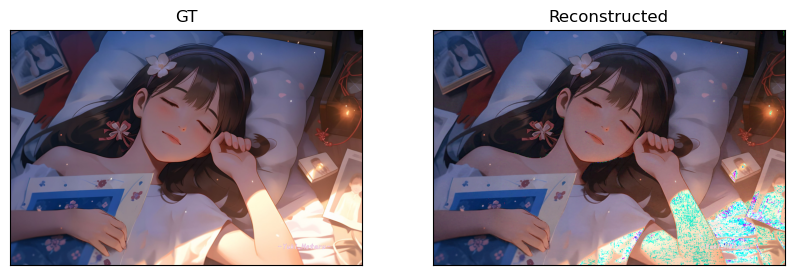

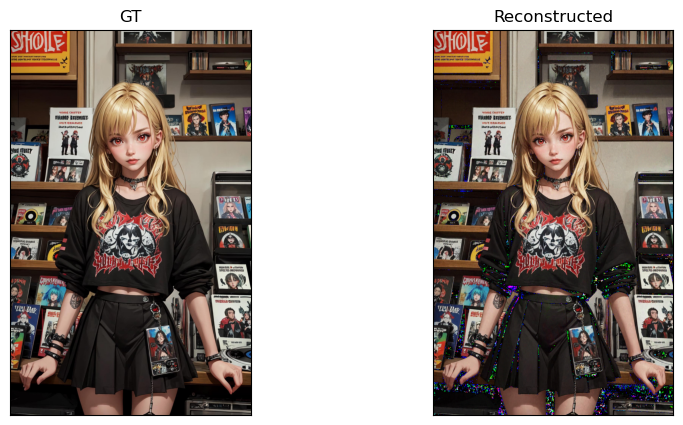

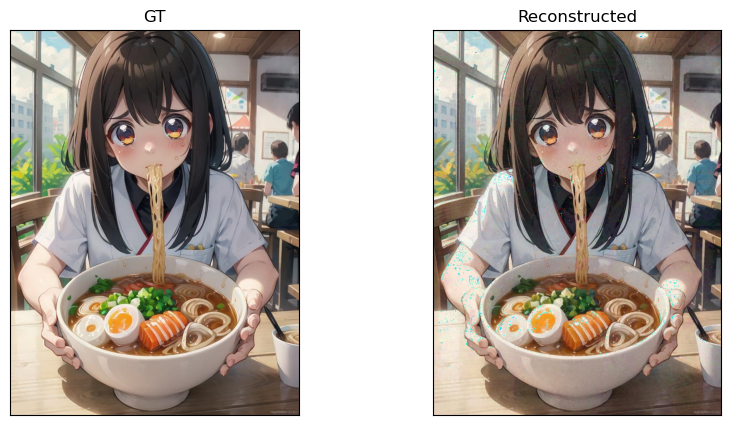

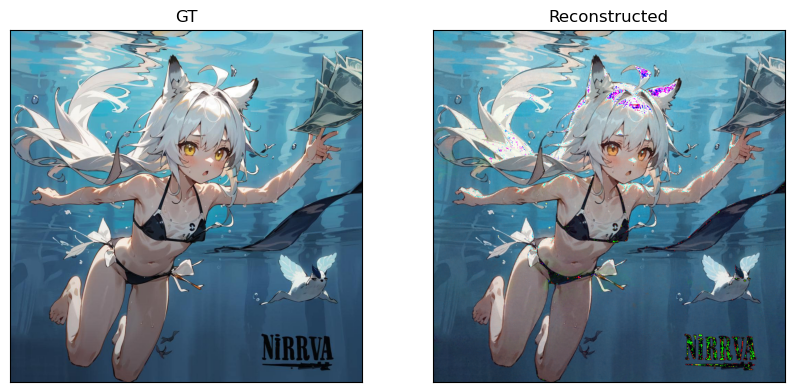

In [9]:
plot_dataset_recon(model, dataset)